In [111]:
from __future__ import print_function, division
from builtins import range, input

In [112]:
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import keras.backend as backend

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

In [114]:
def vgg16_avg_pool(shape):
    vgg = VGG16(input_shape = shape, weights = 'imagenet', include_top = False)
    new_model = Sequential()
    for layer in vgg.layers:
        if (layer.__class__ == MaxPooling2D):
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

In [115]:
def vgg16_avg_pool_cutoff(shape, num_convs):
    if(num_convs < 1 or num_convs > 13):
        print("Input Error!!")
        return None
    model = vgg16_avg_pool(shape)
    new_model = Sequential()
    n = 0
    for layer in model.layers:
        if(layer.__class__ == Conv2D):
            n += 1
        new_model.add(layer)
        if(n >= num_convs):
            break
    return new_model

In [116]:
def unpreprocess(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 126.68
    img = img[:, :, ::-1]
    return img

In [117]:
def scale_image(x):
    return (x - x.min()) / (x.max())

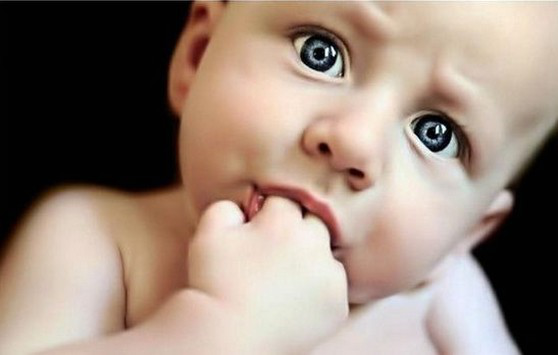

In [118]:
path = 'C:\\Users\\AAKASH\\Desktop\\Temporary\\CN ML attachments\\baby1.jpg'
img = image.load_img(path)
img

In [119]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

In [120]:
batch_shape = x.shape
shape = x.shape[1:]

In [121]:
batch_shape, shape

((1, 355, 558, 3), (355, 558, 3))

In [122]:
content_model = vgg16_avg_pool_cutoff(shape, 5)
target = backend.variable(content_model.predict(x))

In [123]:
content_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 355, 558, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 355, 558, 64)      36928     
_________________________________________________________________
average_pooling2d_31 (Averag (None, 177, 279, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 177, 279, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 177, 279, 128)     147584    
_________________________________________________________________
average_pooling2d_32 (Averag (None, 88, 139, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 88, 139, 256)      295168    
Total para

In [124]:
target

<tf.Variable 'Variable_5:0' shape=(1, 88, 139, 256) dtype=float32_ref>

In [125]:
content_model.input, content_model.output

(<tf.Tensor 'sequential_14_input:0' shape=(?, 355, 558, 3) dtype=float32>,
 <tf.Tensor 'block3_conv1_17/Relu:0' shape=(?, 88, 139, 256) dtype=float32>)

In [126]:
loss = backend.mean(backend.square(target - content_model.output))
grads = backend.gradients(loss, content_model.input)

In [127]:
get_loss_and_grads = backend.function(inputs = [content_model.input], outputs = [loss] + grads)

In [128]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [129]:
t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(1):
    x, l, _ = fmin_l_bfgs_b(func = get_loss_and_grads_wrapper, x0 = x, maxfun = 20)
    x = np.clip(x, -127, 127)
    print('iter: ', i, 'loss: ', l)
    losses.append(l)

iter:  0 loss:  20033.63671875


duration:  0:01:52.318862


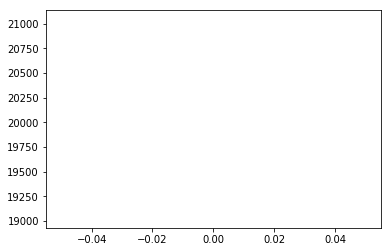

In [130]:
print('duration: ', datetime.now() - t0)
plt.plot(losses)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


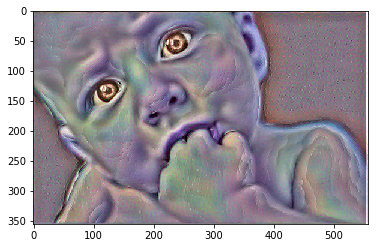

In [131]:
new_img = x.reshape(*batch_shape)
final_img = unpreprocess(new_img)
plt.imshow(scale_image(final_img[0]))
plt.show()